# Bayesian Estimation of Differential Equations

Most of the scientific community deals with the basic problem of trying to mathematically model the reality around them and this often involves dynamical systems. The general trend to model these complex dynamical systems is through the use of differential equations. Differential equation models often have non-measurable parameters. The popular “forward-problem” of simulation consists of solving the differential equations for a given set of parameters, the “inverse problem” to simulation, known as parameter estimation, is the process of utilizing data to determine these model parameters. Bayesian inference provides a robust approach to parameter estimation with quantified uncertainty.

In [2]:
;cd "/Users/aamzallag/code_programming/julia/TuringTutorials"

/Users/aamzallag/code_programming/julia/TuringTutorials


In [3]:
]activate .

 Activating environment at `~/code_programming/julia/TuringTutorials/Project.toml`


In [3]:
]instantiate

In [ ]:
]add Turing#master

In [11]:
import Pkg; Pkg.add("DataFrames")

  Resolving package versions...
Updating `~/code_programming/julia/TuringTutorials/Project.toml`
  [a93c6f00] + DataFrames v0.20.2
No Changes to `~/code_programming/julia/TuringTutorials/Manifest.toml`


In [4]:
using Turing, Distributions, DataFrames, DifferentialEquations, DiffEqSensitivity

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Disable Turing's progress meter for this tutorial.
Turing.turnprogress(false)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/aamzallag/.julia/packages/Turing/j5VJb/src/Turing.jl:22


false

## The Lotka-Volterra Model

The Lotka–Volterra equations, also known as the predator–prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey. The populations change through time according to the pair of equations:

$\frac{dx}{dt} = (\alpha - \beta y)x$
 
$\frac{dy}{dt} = (\delta x - \gamma)y$


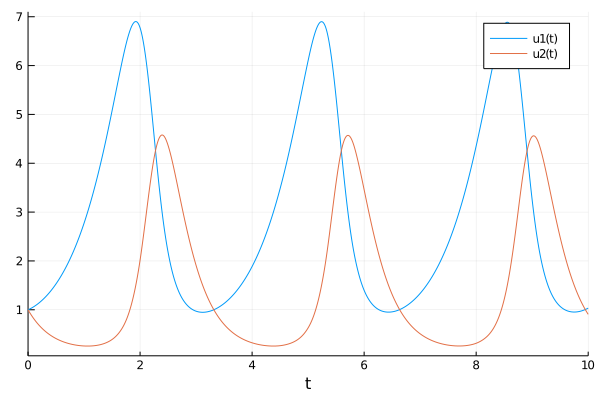

In [5]:
function lotka_volterra(du,u,p,t)
  x, y = u
  α, β, γ, δ  = p
  du[1] = dx = (α - β*y)x
  du[2] = dy = (δ*x - γ)y
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
sol = solve(prob,Tsit5())
plot(sol)

We'll generate the data to use for the parameter estimation from simulation. 
With the `saveat` [argument](https://docs.sciml.ai/latest/basics/common_solver_opts/) we specify that the solution is stored only at `0.1` time units. To make the data look more realistic, we add random noise using the function `randn`.

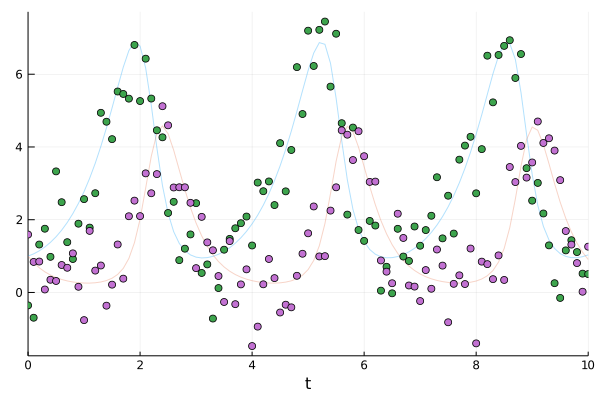

In [6]:
sol = solve(prob,Tsit5(),saveat=0.1)
odedata = hcat([sol[:,i] .+ 0.01randn(2) for i in 1:size(sol,2)]...) 
odedata = odedata + 0.8 * randn(size(odedata))
plot(sol, alpha = 0.3, legend = false); scatter!(sol.t, odedata')

## Direct Handling of Bayesian Estimation with Turing

Turing and DifferentialEquations are completely composable and you can write of the differential equation inside a Turing `@model` and it will just work.

We can rewrite the Lotka Volterra parameter estimation problem with a Turing `@model` interface as below

In [7]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata)
chain = sample(model, NUTS(.65),10_000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/aamzallag/.julia/packages/Turing/j5VJb/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47


Chains MCMC chain (9000×17×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, β, γ, δ, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α    1.4671    0.0484     0.0005    0.0010   2185.9101    1.0001  
           β    1.0379    0.0484     0.0005    0.0009   2922.4577    1.0006  
           γ    3.0984    0.1508     0.0016    0.0030   2269.3793    1.0001  
           δ    1.0408    0.0545     0.0006    0.0011   2199.9069    1.0001  
           σ    0.7806    0.0392     0.0004    0.00

The estimated parameters are close to the desired parameter values. We can also check that the chains have converged in the plot.

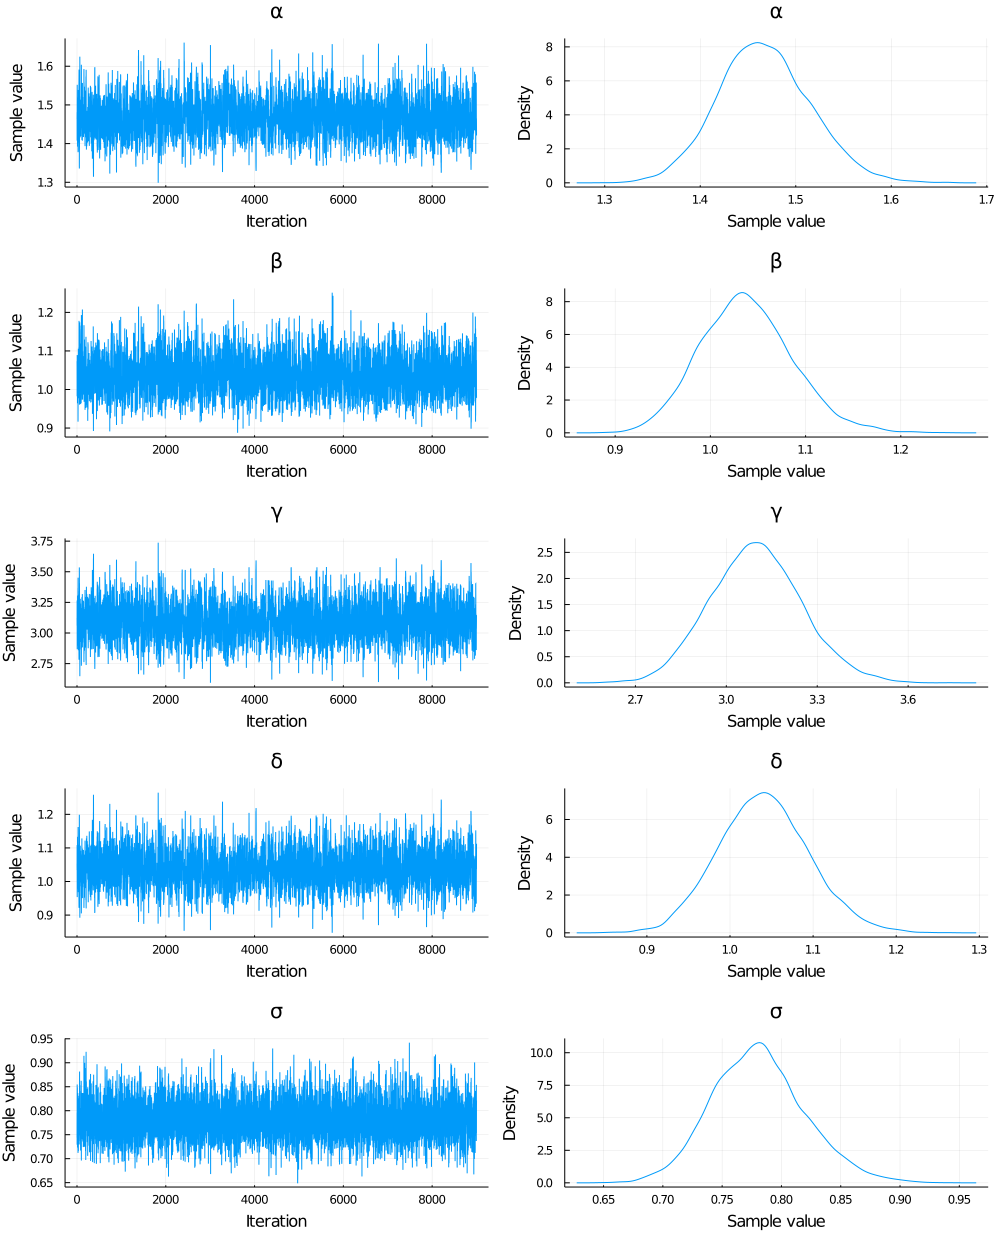

In [8]:
plot(chain)

### Data retrodiction 
In Bayesian analysis it is often useful to retrodict the data, i.e. generate simulated data using samples from the posterior distribution, and compare to the original data (see for instance section 3.3.2 - model checking of McElreath's book "Statistical Rethinking"). Here, we solve again the ODE using the output in `chain`, for 300 randomly picked posterior samples. We plot this ensemble of solutions to check if the solution resembles the data. 

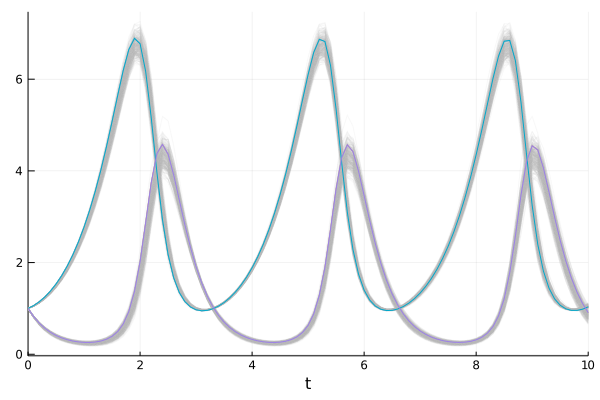

In [9]:
pl = plot(sol, legend = false)
for k in sample(2:size(chain.value, 1), 300) 
    resol = solve(remake(prob,p=chain.value[k, [13, 14, 15, 16]].data),Tsit5(),saveat=0.1)
    plot!(resol, alpha=0.1, color = "#BBBBBB", legend = false)
end
plot!(sol, w=1, legend = false)


In the plot above, the 300 retrodicted time courses from the posterior are plotted in gray, and the original simulated data is in green and purple. We can see that, even though we added quite a bit of noise to the data (see dot plot above), the posterior distribution reproduces quite accurately the "true" ODE solution.

## Fitting Lotka-Volterra with DiffEqBayes

[DiffEqBayes.jl](https://github.com/SciML/DiffEqBayes.jl) is a high level package that set of extension functionality for estimating the parameters of differential equations using Bayesian methods. It allows the choice of using CmdStan.jl, Turing.jl, DynamicHMC.jl and ApproxBayes.jl to perform a Bayesian estimation of a differential equation problem specified via the DifferentialEquations.jl interface. You can read the [docs](https://docs.sciml.ai/latest/analysis/parameter_estimation/#Bayesian-Methods-1) for an understanding of the available functionality.

In [10]:
using DiffEqBayes
t = 0:0.1:10.0
priors = [truncated(Normal(1.5,0.5),0.5,2.5),truncated(Normal(1.2,0.5),0,2),truncated(Normal(3.0,0.5),1,4),truncated(Normal(1.0,0.5),0,2)]
bayesian_result_turing = turing_inference(prob,Tsit5(),t,odedata,priors,num_samples=1_000)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/aamzallag/.julia/packages/Turing/j5VJb/src/inference/hmc.jl:629


Chains MCMC chain (500×17×1 Array{Float64,3}):

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
parameters        = theta[1], theta[2], theta[3], theta[4], σ[1]
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat  
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64  
                                                                            
    theta[1]    1.4671    0.0439     0.0020    0.0028   132.4635    1.0124  
    theta[2]    1.0400    0.0447     0.0020    0.0035   127.5232    1.0136  
    theta[3]    3.0974    0.1419     0.0063    0.0086   148.8445    1.0082  
    theta[4]    1.0412    0.0499     0.0022    0.0030   139.9703    1.0067  
        σ[1]    0.7813    0.04

Here as well, the estimated parameters are clearly very close to the desired parameter values, and
the chain can be plotted here as well, using `plot(bayesian_result_turing)`


## Scaling to Large Models: Adjoint Sensitivities

DifferentialEquations.jl's efficiency for large stiff models has been shown in multiple [benchmarks](https://github.com/SciML/DiffEqBenchmarks.jl). To learn more about how to optimize solving performance for stiff problems you can take a look at the [docs](https://docs.sciml.ai/latest/tutorials/advanced_ode_example/). 

[Sensitivity analysis](https://docs.sciml.ai/latest/analysis/sensitivity/), or automatic differentiation (AD) of the solver, is provided by the DiffEq suite. The model sensitivities are the derivatives of the solution $u(t)$ with respect to the parameters. Specifically, the local sensitivity of the solution to a parameter is defined by how much the solution would change by changes in the parameter. Sensitivity analysis provides a cheap way to calculate the gradient of the solution which can be used in parameter estimation and other optimization tasks.


The AD ecosystem in Julia allows you to switch between forward mode, reverse mode, source to source and other choices of AD and have it work with any Julia code. For a user to make use of this within [SciML](https://sciml.ai), [high level interactions in `solve`](https://docs.sciml.ai/latest/analysis/sensitivity/#High-Level-Interface:-sensealg-1) automatically plug into those AD systems to allow for choosing advanced sensitivity analysis (derivative calculation) [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1). 

More theoretical details on these methods can be found at: https://docs.sciml.ai/latest/extras/sensitivity_math/.

While these sensitivity analysis methods may seem complicated (and they are!), using them is dead simple. Here is a version of the Lotka-Volterra model with adjoints enabled.

All we had to do is switch the AD backend to one of the adjoint-compatible backends (ReverseDiff, Tracker, or Zygote) and boom the system takes over and we're using adjoint methods! Notice that on this model adjoints are slower. This is because adjoints have a higher overhead on small parameter models and we suggest only using these methods for models with around 100 parameters or more. For more details, see https://arxiv.org/abs/1812.01892.

In [11]:
Turing.setadbackend(:zygote)
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,saveat=0.1)
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(odedata)
chain = sample(model, NUTS(.65),1000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/aamzallag/.julia/packages/Turing/j5VJb/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/Adva

Chains MCMC chain (500×17×1 Array{Float64,3}):

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
parameters        = α, β, γ, δ, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat  
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64  
                                                                            
           α    1.2692    0.0876     0.0039    0.0112    60.3737    0.9983  
           β    0.9087    0.1186     0.0053    0.0106   144.8307    1.0026  
           γ    1.0909    0.0867     0.0039    0.0104    58.3241    1.0000  
           δ    0.5474    0.0605     0.0027    0.0076    61.5045    0.9980  
           σ    2.0017    0.0986     0.0044    0.0051   216.7

Now we can exercise control of the sensitivity analysis method that is used by using the `sensealg` keyword argument. Let's choose the `InterpolatingAdjoint` from the available AD [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1) and enable a compiled ReverseDiff vector-Jacobian product:

In [12]:
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,saveat=0.1,sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP(true)))
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(odedata)
@time chain = sample(model, NUTS(.65),1000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/aamzallag/.julia/packages/Turing/j5VJb/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/aamzallag/.julia/packages/Adva

360.674794 seconds (1.52 G allocations: 85.780 GiB, 7.20% gc time)


Chains MCMC chain (500×17×1 Array{Float64,3}):

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
parameters        = α, β, γ, δ, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat  
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64  
                                                                            
           α    0.5158    0.0169     0.0008    0.0012   176.6483    1.0118  
           β    0.9990    0.2300     0.0103    0.0136   157.7118    0.9987  
           γ    2.6149    0.4013     0.0179    0.0322   123.3910    1.0086  
           δ    0.9737    0.1372     0.0061    0.0106   128.3100    1.0053  
           σ    2.0971    0.1009     0.0045    0.0049   244.8

For more examples of adjoint usage on large parameter models, consult the [DiffEqFlux documentation](https://diffeqflux.sciml.ai/dev/)

## Including Process Noise: Estimation of Stochastic Differential Equations

This can be easily extended to Stochastic Differential Equations as well.

Let's create the Lotka Volterra equation with some noise and try out estimating it with the same framework we have set up before.

Our equations now become:

$dx = (\alpha - \beta y)xdt + \phi_1 xdW_1$

$dy = (\delta x - \gamma)ydt + \phi_2 ydW_2$

In [13]:
function lotka_volterra_noise(du,u,p,t)
    du[1] = p[5]*u[1]
    du[2] = p[6]*u[2]
end
p = [1.5, 1.0, 3.0, 1.0, 0.3, 0.3]
prob = SDEProblem(lotka_volterra,lotka_volterra_noise,u0,(0.0,10.0),p)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

Solving it repeatedly confirms the randomness of the solution

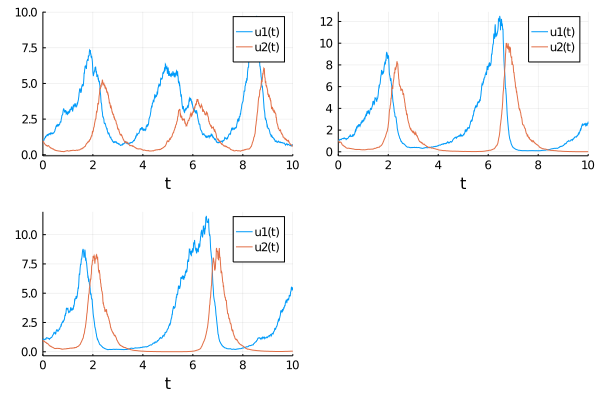

In [14]:
sol = solve(prob,saveat=0.01)
p1 = plot(sol)
sol = solve(prob,saveat=0.01)
p2 = plot(sol)
sol = solve(prob,saveat=0.01)
p3 = plot(sol)
plot(p1,p2,p3)

With the `MonteCarloSummary` it is easy to summarize the results from multiple runs through the `EnsembleProblem` interface, here we run the problem for 1000 `trajectories` and visualize the summary:

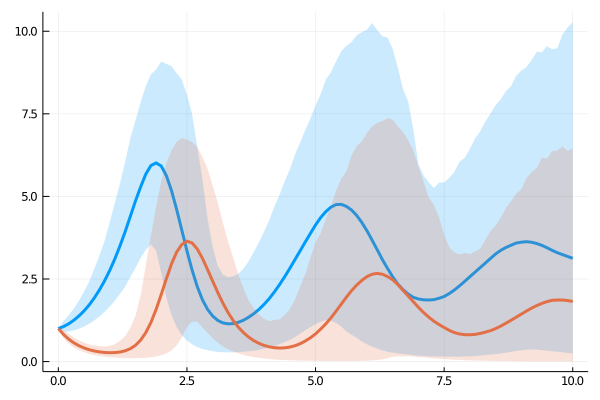

In [15]:
sol = solve(EnsembleProblem(prob),SRIW1(),saveat=0.1,trajectories=5000)
summ = EnsembleSummary(sol)
plot(summ)

Get data from the means to fit:

In [16]:
using DiffEqBase.EnsembleAnalysis
averagedata,real_vars = Array.(timeseries_steps_meanvar(sol))

([1.0 1.058835094318822 … 3.182519610358562 3.124533203424575; 1.0 0.8227489938512195 … 1.8473251735045646 1.8209644538361056], [0.0 0.009750145978454068 … 9.91605889356512 10.375250826351328; 0.0 0.005928057165163848 … 4.834965204576706 4.813752665268599])

Now fit the means with Turing.

We will utilize multithreading with the [`EnsembleProblem`](https://docs.sciml.ai/stable/tutorials/sde_example/#Ensemble-Simulations-1) interface to speed up the SDE parameter estimation.

In [17]:
Threads.nthreads()

4

In [ ]:
Turing.setadbackend(:forwarddiff)
@model function fitlv(data)
    σ1 ~ Normal(0.0,0.1)
    σ2 ~ Normal(0.0,0.1)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    ϕ1 ~ truncated(Normal(1.2,0.5),0.1,1)
    ϕ2 ~ truncated(Normal(1.2,0.5),0.1,1)
    p = [α,β,γ,δ,ϕ1,ϕ2]
    prob = SDEProblem(lotka_volterra,lotka_volterra_noise,u0,(0.0,10.0),p)
    ensemble_predicted = solve(EnsembleProblem(prob),SRIW1(),saveat=0.1,trajectories=5000)
    try 
        predicted_means, predicted_vars = timeseries_steps_meanvar(ensemble_predicted)
        for i = 1:length(predicted_means)
            data[1][:,i] ~ MvNormal(predicted_means[i], σ1)
            #data[2][:,i] ~ MvNormal(predicted_vars[i], σ2)
        end
    catch e
        return 0.0
    end
end;
model = fitlv([averagedata, real_vars])
chain = sample(model, NUTS(0.45), 1000, progress=true)